In [488]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.fftpack
from sklearn.decomposition import PCA
from math import log2



In [489]:
#load Insulin and CGM Data
insulinDf = pandas.read_csv('InsulinData.csv', parse_dates=[['Date','Time']],low_memory=False).iloc[::-1]
cgmDf = pandas.read_csv('CGMData.csv', parse_dates=[['Date','Time']],low_memory=False).iloc[::-1]

cgmDf

,Date_Time,Index,New Device Time,BG Reading (mg/dL),Linked BG Meter ID,Basal Rate (U/h),Temp Basal Amount,Temp Basal Type,Temp Basal Duration (h:mm:ss),Bolus Type,...,Scroll Step Size,Insulin Action Curve Time,Sensor Calibration Rejected Reason,Preset Bolus,Bolus Source,Network Device Associated Reason,Network Device Disassociated Reason,Network Device Disconnected Reason,Sensor Exception,Preset Temp Basal Name
55342,2017-07-25 12:08:54,52859,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55341,2017-07-25 12:13:54,52858,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55340,2017-07-25 12:18:54,52857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55339,2017-07-25 12:23:54,52856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55338,2017-07-25 12:28:54,52855,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,2018-02-12 13:02:27,20359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SENSOR_ERROR,NaN
3,2018-02-12 13:07:27,20358,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SENSOR_ERROR,NaN
2,2018-02-12 13:12:27,20357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SENSOR_ERROR,NaN
1,2018-02-12 13:17:27,20356,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [490]:
insulinDFColY = insulinDf[insulinDf['BWZ Carb Input (grams)'].notnull() & insulinDf['BWZ Carb Input (grams)'] != 0]
insulinMealDates = pandas.DataFrame(insulinDFColY[['Date_Time','BWZ Carb Input (grams)']])
insulinMealDates

,Date_Time,BWZ Carb Input (grams)
41401,2017-07-25 10:21:19,91.0
41393,2017-07-25 10:39:46,58.0
41347,2017-07-25 18:31:40,115.0
41274,2017-07-26 09:27:16,72.0
41265,2017-07-26 11:24:52,20.0
...,...,...
222,2018-02-11 16:27:04,40.0
207,2018-02-11 18:14:37,8.0
188,2018-02-11 20:33:18,71.0
129,2018-02-12 02:30:55,15.0


In [491]:
insulinMealDates['Diff'] = insulinMealDates.iloc[:,0].diff(-1).dt.total_seconds().div(3600)
insulinMealDates = insulinMealDates.loc[insulinMealDates['Diff'] <= -2]
insulinMealDates.drop(insulinMealDates.head(1).index,inplace=True)
insulinMealDates.drop(insulinMealDates.tail(2).index,inplace=True)
insulinMealDates

/home/arun/.local/lib/python3.8/site-packages/pandas/core/frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,Date_Time,BWZ Carb Input (grams),Diff
41347,2017-07-25 18:31:40,115.0,-14.926667
41261,2017-07-26 12:48:41,63.0,-6.440278
41214,2017-07-26 19:15:06,60.0,-10.512500
41172,2017-07-27 05:45:51,24.0,-3.563889
41164,2017-07-27 09:19:41,47.0,-4.618889
...,...,...,...
486,2018-02-10 14:48:11,90.0,-4.971389
432,2018-02-10 19:46:28,40.0,-14.264167
300,2018-02-11 10:02:19,10.0,-2.684444
261,2018-02-11 12:43:23,27.0,-2.850833


In [492]:
binLen = 20
minV = insulinMealDates['BWZ Carb Input (grams)'].min()
maxV = insulinMealDates['BWZ Carb Input (grams)'].max()
minV,maxV

(3.0, 129.0)

In [493]:
nBins = (int)((maxV - minV)/20)
nBins

6

In [494]:
for ind in insulinMealDates.index:
    insulinMealDates['BWZ Carb Input (grams)'][ind] = (int)(insulinMealDates['BWZ Carb Input (grams)'][ind]/(minV + 20))
#     23,43,63,83,103,123,
insulinMealDates

<ipython-input-494-d3a3e1d2858f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  insulinMealDates['BWZ Carb Input (grams)'][ind] = (int)(insulinMealDates['BWZ Carb Input (grams)'][ind]/(minV + 20))
/usr/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


,Date_Time,BWZ Carb Input (grams),Diff
41347,2017-07-25 18:31:40,5.0,-14.926667
41261,2017-07-26 12:48:41,2.0,-6.440278
41214,2017-07-26 19:15:06,2.0,-10.512500
41172,2017-07-27 05:45:51,1.0,-3.563889
41164,2017-07-27 09:19:41,2.0,-4.618889
...,...,...,...
486,2018-02-10 14:48:11,3.0,-4.971389
432,2018-02-10 19:46:28,1.0,-14.264167
300,2018-02-11 10:02:19,0.0,-2.684444
261,2018-02-11 12:43:23,1.0,-2.850833


In [495]:
minVi = insulinMealDates['BWZ Carb Input (grams)'].min()
maxVi = insulinMealDates['BWZ Carb Input (grams)'].max()
minVi,maxVi

(0.0, 5.0)

In [496]:
mealDatesList = []
for ind in insulinMealDates.index: 
#     print("InsulinMealData : " + str(insulinMealDates['Date_Time'][ind]))
    l = []
    l.append((cgmDf.loc[cgmDf['Date_Time'] >= insulinMealDates['Date_Time'][ind]])['Date_Time'].iloc[0])
    l.append(insulinMealDates['BWZ Carb Input (grams)'][ind])
    mealDatesList.append(l)
mealDatesList

[[Timestamp('2017-07-25 18:33:55'), 5.0],
 [Timestamp('2017-07-26 12:49:00'), 2.0],
 [Timestamp('2017-07-26 19:19:01'), 2.0],
 [Timestamp('2017-07-27 05:49:05'), 1.0],
 [Timestamp('2017-07-27 09:24:05'), 2.0],
 [Timestamp('2017-07-27 13:59:06'), 2.0],
 [Timestamp('2017-07-27 18:59:08'), 3.0],
 [Timestamp('2017-07-28 08:54:11'), 3.0],
 [Timestamp('2017-07-28 15:19:12'), 2.0],
 [Timestamp('2017-07-28 21:39:14'), 2.0],
 [Timestamp('2017-07-29 18:09:19'), 4.0],
 [Timestamp('2017-07-29 21:34:19'), 1.0],
 [Timestamp('2017-07-30 18:29:26'), 3.0],
 [Timestamp('2017-07-31 05:49:29'), 1.0],
 [Timestamp('2017-07-31 09:54:29'), 2.0],
 [Timestamp('2017-07-31 13:02:12'), 0.0],
 [Timestamp('2017-07-31 15:07:12'), 5.0],
 [Timestamp('2017-07-31 18:12:12'), 0.0],
 [Timestamp('2017-08-01 05:52:15'), 1.0],
 [Timestamp('2017-08-01 09:52:17'), 1.0],
 [Timestamp('2017-08-01 13:47:17'), 3.0],
 [Timestamp('2017-08-01 18:17:17'), 0.0],
 [Timestamp('2017-08-01 20:37:20'), 1.0],
 [Timestamp('2017-08-02 05:57:21')

In [518]:
mealDataMatrix = []
for mealDateTime in mealDatesList:
    idx = cgmDf[cgmDf['Date_Time'] == mealDateTime[0]]['Sensor Glucose (mg/dL)'].index[0]
    l = list(cgmDf['Sensor Glucose (mg/dL)'].iloc[cgmDf.shape[0]-1-idx-6:cgmDf.shape[0]-1-idx+24].values)
    l.append(mealDateTime[1])
    mealDataMatrix.append(l)
mealDataMatrix

[[58.0,
  59.0,
  63.0,
  71.0,
  81.0,
  102.0,
  131.0,
  140.0,
  147.0,
  153.0,
  159.0,
  163.0,
  159.0,
  153.0,
  151.0,
  155.0,
  163.0,
  164.0,
  nan,
  166.0,
  168.0,
  164.0,
  169.0,
  178.0,
  184.0,
  190.0,
  195.0,
  198.0,
  203.0,
  196.0,
  5.0],
 [304.0,
  292.0,
  281.0,
  268.0,
  259.0,
  255.0,
  248.0,
  241.0,
  231.0,
  220.0,
  222.0,
  222.0,
  222.0,
  223.0,
  224.0,
  228.0,
  233.0,
  243.0,
  256.0,
  262.0,
  270.0,
  277.0,
  274.0,
  269.0,
  267.0,
  267.0,
  274.0,
  284.0,
  283.0,
  278.0,
  2.0],
 [40.0,
  40.0,
  40.0,
  40.0,
  60.0,
  71.0,
  83.0,
  87.0,
  100.0,
  112.0,
  121.0,
  125.0,
  130.0,
  132.0,
  123.0,
  112.0,
  89.0,
  77.0,
  69.0,
  66.0,
  67.0,
  71.0,
  75.0,
  74.0,
  72.0,
  70.0,
  67.0,
  74.0,
  77.0,
  81.0,
  2.0],
 [212.0,
  210.0,
  204.0,
  200.0,
  199.0,
  201.0,
  201.0,
  194.0,
  188.0,
  183.0,
  181.0,
  176.0,
  170.0,
  168.0,
  169.0,
  172.0,
  179.0,
  192.0,
  203.0,
  205.0,
  210.0,
  213.

In [517]:
mealDf = pandas.DataFrame(mealDataMatrixWithGT).dropna()
mealDf = mealDf.reset_index(drop=True)
mealDfAvg = mealDf.iloc[:,:-1].mean(axis=0)
mealDf

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,304.0,292.0,281.0,268.0,259.0,255.0,248.0,241.0,231.0,220.0,...,277.0,274.0,269.0,267.0,267.0,274.0,284.0,283.0,278.0,2.0
1,40.0,40.0,40.0,40.0,60.0,71.0,83.0,87.0,100.0,112.0,...,71.0,75.0,74.0,72.0,70.0,67.0,74.0,77.0,81.0,2.0
2,212.0,210.0,204.0,200.0,199.0,201.0,201.0,194.0,188.0,183.0,...,213.0,212.0,216.0,213.0,210.0,210.0,209.0,210.0,209.0,1.0
3,145.0,141.0,137.0,133.0,129.0,124.0,125.0,122.0,123.0,130.0,...,196.0,189.0,183.0,179.0,177.0,173.0,165.0,153.0,152.0,2.0
4,40.0,40.0,46.0,53.0,57.0,57.0,55.0,58.0,70.0,77.0,...,140.0,147.0,157.0,172.0,175.0,183.0,191.0,198.0,200.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455,195.0,201.0,213.0,225.0,260.0,278.0,290.0,293.0,291.0,294.0,...,349.0,353.0,367.0,380.0,381.0,386.0,383.0,379.0,379.0,0.0
456,149.0,150.0,154.0,158.0,162.0,159.0,156.0,148.0,146.0,150.0,...,252.0,249.0,236.0,234.0,232.0,226.0,227.0,232.0,242.0,3.0
457,61.0,59.0,59.0,60.0,65.0,70.0,82.0,100.0,126.0,133.0,...,153.0,158.0,162.0,169.0,163.0,155.0,136.0,114.0,106.0,1.0
458,57.0,58.0,62.0,74.0,104.0,110.0,126.0,133.0,135.0,141.0,...,174.0,207.0,209.0,206.0,197.0,185.0,191.0,197.0,202.0,0.0


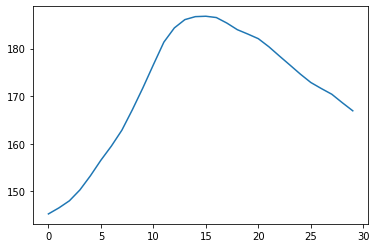

In [499]:
plt.plot(mealDfAvg)
plt.show()

In [500]:
#Extract cgm velocity
def extract_cgm_velocity(df, result_df):
  velocityDF = pd.DataFrame()
  for i in range(0,df.shape[1]-5):
      velocityDF['Vel_'+str(i)] = (df.iloc[:,i+5]-df.iloc[:,i])
  result_df['Window_Velocity_Max']=velocityDF.max(axis = 1, skipna=True)

#Extract cgm trend
def extract_cgm_trend(df, result_df):
    lunch = [[]]
    means = []
    for i in range(1, len(df)):
        lunch.append(df.iloc[i])
    for i in range(0, len(lunch)):
        means.append(df.iloc[i].mean())
    countmaster = []
    for i in range(0, len(lunch)):
        count = 0
        for j in df.iloc[i]:
            if j < means[i]:    
                count += 1
        countmaster.append(count)
    percentage=[]
    for i in countmaster:
        percentage.append((i / len(df.iloc[0])) * 100)
    result_df['cgmTrend'] = np.asarray(percentage)

#Extract Accelaration
def extract_acceleration(df, result_df):
    d=[]
    q=[]
    f=[]
    acc = [[],[],[],[]]
    for j in range(0, df.shape[0]):
        b = df.iloc[j]
        d = []
        for i in range(len(b)):
            if(np.isnan(b[i])):
                continue
            else:
                d.append(b[i])

        if(len(d) >= 1):
            solar_elevation_angle_1stdev = np.gradient(d)
            solar_elevation_angle_2nddev = np.gradient(solar_elevation_angle_1stdev)

            q = solar_elevation_angle_2nddev
            arr = q[5:10]
            acc[0].append(np.mean(arr))
            arr = q[10:15]
            acc[1].append(np.mean(arr))
            arr = q[15:20]
            acc[2].append(np.mean(arr))
            arr = q[20:25]
            acc[3].append(np.mean(arr))

        else:
            for i in range(4):
              acc[i].append(0)
    for i in range(4):
      result_df['acc'+str(i+1)] = acc[i]

#Extract entropy
def get_entropy(series):
    series_counts = series.value_counts()
    entropy = scipy.stats.entropy(series_counts)  
    return entropy

def extract_entropy(df, result_df):
    result_df['Entropy'] = df.apply(lambda row: get_entropy(row), axis=1)

#Extract Windowed mean
def extract_windowed_mean(df, result_df):
  if(df.shape[1] > 24):
    for i in range(6,df.shape[1],6):
      result_df['Mean_'+str(i-6)] = df.iloc[:,i:i+6].mean(axis = 1)
  else:
    for i in range(0,df.shape[1],6):
      result_df['Mean_'+str(i)] = df.iloc[:,i:i+6].mean(axis = 1)

# FFT- Finding top 8 values for each row
from numpy.fft import fft
def get_fft(row):
    cgmFFTValues = np.abs(fft(row))
    cgmFFTValues.sort()
    return np.flip(cgmFFTValues)[0:8]

def extract_fft(df, result_df):
  FFT = pd.DataFrame()
  FFT['FFT_Top2'] = df.apply(lambda row: get_fft(row), axis=1)
  FFT_updated = pd.DataFrame(FFT.FFT_Top2.tolist(), columns=['FFT_1', 'FFT_2', 'FFT_3', 'FFT_4', 'FFT_5', 'FFT_6', 'FFT_7', 'FFT_8'])
  FFT_updated.head()
  for i in range(8):
    result_df['FFT_'+str(i+1)] = FFT_updated['FFT_'+str(i+1)]
    
#get MinMaxDiff for each row
def get_minMaxDiff(series):
    return series.max() - series.min()
    
#Extract MinMaxDiff
def extract_minMaxDiff(df, result_df):
    result_df['MinMaxDifference']= df.apply(lambda row: get_minMaxDiff(row), axis=1)   
    

In [531]:
#1. Feature extraction
meal_features = pd.DataFrame()
result_dffft = pd.DataFrame()

def extract_features(data, result_df):
    extract_minMaxDiff(data, result_df)
    extract_cgm_velocity(data, result_df)
    extract_windowed_mean(data, result_df)
    extract_cgm_trend(data, result_df)
    extract_acceleration(data, result_df)
    extract_entropy(data, result_df)
    extract_fft(data, result_df)    

extract_features(mealDf.iloc[:,:-1], meal_features)
meal_features_withGT = meal_features.join(mealDf[30])
meal_features


,MinMaxDifference,Window_Velocity_Max,Mean_0,Mean_6,Mean_12,Mean_18,cgmTrend,acc1,acc2,acc3,acc4,Entropy,FFT_1,FFT_2,FFT_3,FFT_4,FFT_5,FFT_6,FFT_7,FFT_8
0,84.0,44.0,230.666667,228.833333,268.000000,275.500000,43.333333,0.85,1.05,0.75,-1.20,3.198917,7677.0,475.903609,475.903609,132.355707,132.355707,90.231491,90.231491,43.134985
1,92.0,60.0,104.666667,110.500000,70.333333,73.500000,63.333333,-1.00,-4.40,2.85,-0.60,2.985309,2445.0,436.384942,436.384942,322.178882,322.178882,112.491733,112.491733,51.884487
2,48.0,38.0,187.166667,175.000000,209.833333,210.166667,36.666667,-0.85,1.40,0.05,-1.20,2.948118,5919.0,291.275268,291.275268,122.914246,122.914246,51.526117,51.526117,32.078030
3,91.0,62.0,135.166667,194.333333,197.500000,166.500000,50.000000,3.55,-0.70,-3.25,0.45,3.354988,4970.0,613.565611,613.565611,145.278432,145.278432,33.327863,33.327863,32.558647
4,160.0,50.0,74.333333,122.500000,138.666667,186.500000,46.666667,1.85,-0.65,-0.50,0.65,3.262568,3425.0,806.607594,806.607594,464.817995,464.817995,271.339713,271.339713,199.922485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455,191.0,89.0,299.000000,334.166667,351.666667,381.333333,40.000000,-2.10,-1.70,-0.15,0.80,3.354988,9569.0,808.994745,808.994745,537.338656,537.338656,396.613636,396.613636,289.094803
456,106.0,88.0,150.833333,169.000000,226.166667,232.166667,60.000000,0.70,-1.35,4.60,-4.30,3.262568,5601.0,683.598105,683.598105,213.235198,213.235198,206.052748,206.052748,106.083407
457,110.0,68.0,116.833333,112.666667,147.666667,140.500000,46.666667,-1.30,-0.40,1.95,-2.25,3.308778,3480.0,515.095250,515.095250,472.403892,472.403892,73.742913,73.742913,56.395871
458,152.0,71.0,136.000000,139.833333,178.000000,196.333333,56.666667,-2.65,-1.45,2.80,-3.25,3.170148,4366.0,600.391832,600.391832,537.011660,537.011660,216.785819,216.785819,194.585768


In [529]:
mealDf[30]

0      2.0
1      2.0
2      1.0
3      2.0
4      2.0
      ... 
455    0.0
456    3.0
457    1.0
458    0.0
459    1.0
Name: 30, Length: 460, dtype: float64

In [502]:
# # PCA
pca = PCA(n_components=10)
#Fit meal features
principalComponents = pca.fit(meal_features)
#Transform meal features
PCA_mealdata = pca.fit_transform(meal_features)
PCA_mealdata

array([[ 2.44371360e+03, -7.40997392e+02, -1.25955747e+02, ...,
         1.36833233e+01,  1.78685299e+01,  3.91271401e+00],
       [-2.71432402e+03,  1.75389346e+02,  1.82403709e+02, ...,
         6.12411061e+00, -5.78553431e+00, -5.10351806e+00],
       [ 6.63550165e+02, -6.98805792e+02, -6.79919249e+01, ...,
         7.87222585e+00,  3.69150757e+00,  9.79371121e+00],
       ...,
       [-1.66565315e+03,  1.47014770e+02,  2.98843188e+02, ...,
         3.23755995e+00,  1.31382650e+01,  1.94374615e+00],
       [-7.56844334e+02,  1.73168695e+02,  4.42732304e+02, ...,
         1.97061512e+01,  1.64724773e+01, -1.99659148e+00],
       [ 8.06598433e+02, -8.29548280e+02, -1.47499193e+01, ...,
         1.07931038e+01, -1.25241185e+01, -7.76025926e-02]])

In [503]:
pcaDF = pd.DataFrame(PCA_mealdata)
pcaDF

,0,1,2,3,4,5,6,7,8,9
0,2443.713597,-740.997392,-125.955747,-15.596171,-49.188081,25.998317,37.753333,13.683323,17.868530,3.912714
1,-2714.324019,175.389346,182.403709,96.957808,-1.318064,-30.101505,14.875416,6.124111,-5.785534,-5.103518
2,663.550165,-698.805792,-67.991925,15.835994,-43.726839,27.394704,21.167234,7.872226,3.691508,9.793711
3,-197.652265,-99.599130,-176.696738,56.769232,-70.292610,-2.434050,-1.760295,-19.683615,10.377146,2.756266
4,-1641.470860,596.070077,314.210699,-53.711628,-30.786914,8.269241,-1.158685,-0.080178,-5.025193,-22.290587
...,...,...,...,...,...,...,...,...,...,...
455,4438.965020,-397.199000,424.348688,-134.395839,-10.389320,-17.135727,-30.254966,24.944314,-3.120823,-6.518522
456,455.421003,-50.180524,-15.229873,-111.024798,-21.193774,-25.412511,28.173474,22.144794,12.183237,22.574483
457,-1665.653151,147.014770,298.843188,200.928318,-125.414734,4.409785,22.914013,3.237560,13.138265,1.943746
458,-756.844334,173.168695,442.732304,53.592002,-70.599881,13.934332,-24.790084,19.706151,16.472477,-1.996591


In [504]:
def CalcEucDist(a,b):
    return np.linalg.norm(a-b)
minimum = PCA_mealdata.max() 
for i in range(len(PCA_mealdata)):
    for j in range(len(PCA_mealdata[i])):
        if(CalcEucDist(PCA_mealdata[i][0], PCA_mealdata[i][j]) != 0 and CalcEucDist(PCA_mealdata[i][0], PCA_mealdata[i][j])< minimum):
            minimum = CalcEucDist(PCA_mealdata[i][0], PCA_mealdata[i][j])
        
minimum

0.28818058600552376

In [460]:
PCA_mealdata

array([[ 2.44371360e+03, -7.40997392e+02, -1.25955747e+02, ...,
         1.36833233e+01,  1.78685299e+01,  3.91271401e+00],
       [-2.71432402e+03,  1.75389346e+02,  1.82403709e+02, ...,
         6.12411061e+00, -5.78553431e+00, -5.10351806e+00],
       [ 6.63550165e+02, -6.98805792e+02, -6.79919249e+01, ...,
         7.87222585e+00,  3.69150757e+00,  9.79371121e+00],
       ...,
       [-1.66565315e+03,  1.47014770e+02,  2.98843188e+02, ...,
         3.23755995e+00,  1.31382650e+01,  1.94374615e+00],
       [-7.56844334e+02,  1.73168695e+02,  4.42732304e+02, ...,
         1.97061512e+01,  1.64724773e+01, -1.99659148e+00],
       [ 8.06598433e+02, -8.29548280e+02, -1.47499193e+01, ...,
         1.07931038e+01, -1.25241185e+01, -7.76025926e-02]])

In [505]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=nBins, random_state=0).fit(PCA_mealdata)
kmeans.labels_

# array([[10.,  2.],
#        [ 1.,  2.]])

array([4, 2, 5, 3, 2, 3, 3, 5, 2, 1, 5, 2, 3, 3, 3, 1, 2, 3, 3, 2, 1, 3,
       2, 3, 0, 5, 0, 5, 5, 1, 0, 3, 4, 5, 0, 4, 2, 1, 1, 3, 5, 3, 2, 0,
       2, 2, 3, 4, 2, 1, 1, 2, 2, 2, 1, 1, 2, 4, 1, 1, 3, 5, 1, 4, 0, 0,
       0, 4, 2, 5, 1, 1, 3, 1, 5, 0, 3, 3, 4, 4, 4, 0, 3, 5, 2, 1, 1, 2,
       1, 3, 5, 3, 1, 1, 5, 1, 2, 4, 2, 0, 5, 5, 1, 5, 1, 2, 1, 1, 1, 5,
       5, 1, 2, 1, 2, 1, 2, 1, 0, 1, 3, 3, 1, 5, 4, 2, 3, 5, 3, 0, 1, 1,
       0, 5, 1, 2, 3, 1, 5, 3, 1, 2, 3, 1, 1, 2, 2, 3, 5, 5, 1, 5, 0, 1,
       0, 3, 1, 3, 3, 0, 5, 2, 3, 3, 5, 3, 3, 3, 0, 2, 3, 0, 1, 3, 1, 0,
       3, 4, 3, 1, 3, 1, 1, 2, 3, 3, 1, 2, 1, 4, 3, 2, 4, 3, 0, 2, 2, 3,
       3, 0, 2, 3, 1, 2, 2, 3, 3, 0, 4, 1, 1, 1, 3, 1, 3, 3, 1, 2, 2, 1,
       1, 2, 3, 1, 1, 1, 2, 4, 5, 3, 2, 5, 2, 2, 4, 5, 2, 1, 2, 2, 2, 2,
       3, 0, 2, 2, 2, 2, 1, 3, 2, 5, 1, 5, 3, 2, 5, 0, 2, 5, 3, 1, 3, 1,
       2, 2, 1, 1, 2, 2, 3, 1, 3, 1, 1, 5, 3, 1, 5, 1, 1, 5, 0, 3, 5, 1,
       3, 2, 3, 1, 5, 3, 1, 3, 2, 1, 5, 0, 2, 1, 2,

In [515]:
SSEKMeans = kmeans.inertia_
SSEKMeans

160964517.7506346

In [513]:
def calcEntropyPurity(labels):
    clusterBinMatrix = [[0 for i in range(nBins)] for i in range(nBins)]
    print(clusterBinMatrix)
    for i in range(labels.shape[0]):
        clusterBinMatrix[labels[i]][int(mealDf.iloc[i][30])] += 1
    print(clusterBinMatrix)
    WholeEntropy = 0
    Entropy = [0 for i in range(6)]
    Purity = 0
    totalPoints = sum(sum(clusterBinMatrix,[]))
    for i in range(len(clusterBinMatrix)):
        Purity += max(clusterBinMatrix[i])/totalPoints
        for j in range(len(clusterBinMatrix[i])):
            P = clusterBinMatrix[i][j]/sum(clusterBinMatrix[i])
            if(P != 0):
                Entropy[i] += (-P) * log2(P) * (sum(clusterBinMatrix[i])/totalPoints)
    WholeEntropy = sum(Entropy)
    return WholeEntropy,Purity   

In [514]:
calcEntropy(kmeans.labels_)

[[0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]]
[[8, 19, 10, 5, 0, 0], [45, 42, 22, 16, 6, 0], [25, 30, 26, 8, 3, 1], [22, 34, 27, 12, 1, 0], [13, 7, 3, 5, 1, 0], [20, 29, 14, 5, 1, 0]]


11.784985779130784

In [463]:
clusterBinMatrix = [[0 for i in range(nBins)] for i in range(nBins)]
clusterBinMatrix

[[0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0]]

In [464]:
for i in range(kmeans.labels_.shape[0]):
    clusterBinMatrix[kmeans.labels_[i]][int(mealDf.iloc[i][30])] += 1
clusterBinMatrix
# type(int(mealDf.iloc[i][30].item()))

[[8, 19, 10, 5, 0, 0],
 [45, 42, 22, 16, 6, 0],
 [25, 30, 26, 8, 3, 1],
 [22, 34, 27, 12, 1, 0],
 [13, 7, 3, 5, 1, 0],
 [20, 29, 14, 5, 1, 0]]

In [470]:
Entropy = [0 for i in range(6)]
Purity = [0 for i in range(6)]
for i in range(len(clusterBinMatrix)):
    for j in range(len(clusterBinMatrix[i])):
        P = clusterBinMatrix[i][j]/sum(clusterBinMatrix[i])
        if(P != 0):
            Entropy[i] += (-P) * log2(P)
        
Entropy = sum(Entropy)
EntropyKMeans = Entropy
print(Entropy)

11.784985779130784


In [435]:
from sklearn.cluster import DBSCAN 
db_default = DBSCAN(eps = 224, min_samples = 6).fit(PCA_mealdata) 
labels = db_default.labels_ 
labels
#224,6
# kmeans = KMeans(n_clusters=nBins, random_state=0).fit(PCA_mealdata)
# kmeans.labels_


# dbscan = DBSCAN(9.09, 3)
# dbscan.fit(X)
# labels = dbscan.labels_.tolist()


array([-1, -1,  3,  0, -1,  1, -1, -1,  0,  0, -1,  0,  0,  1,  1,  0,  0,
        2, -1,  0,  0,  1, -1, -1, -1, -1, -1, -1, -1,  4, -1, -1, -1, -1,
       -1, -1, -1,  0, -1,  2,  3, -1,  0, -1,  0, -1,  1, -1, -1,  0, -1,
        0,  0,  0,  0,  0, -1, -1, -1,  0,  2, -1,  0, -1, -1, -1, -1, -1,
        0, -1,  0,  0, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1,  0,
        0,  0,  0,  0, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1,  3,
        0, -1,  0,  0,  0,  0, -1, -1, -1,  4,  0, -1,  0, -1, -1,  0, -1,
        0,  1,  0, -1, -1, -1, -1, -1,  3,  1, -1, -1,  0, -1, -1, -1,  0,
       -1, -1, -1,  1,  0,  0, -1,  0,  0,  0,  0,  0, -1,  5,  0, -1, -1,
       -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,
       -1, -1,  0, -1,  0, -1,  2, -1,  0,  0, -1, -1,  0,  0, -1,  1,  0,
       -1,  0, -1, -1,  0, -1,  2, -1,  0, -1,  1, -1, -1,  0,  0, -1,  0,
        0, -1, -1, -1, -1,  0,  0, -1, -1,  0,  1, -1, -1,  0,  0,  0, -1,
        0,  1,  0,  0,  0

In [438]:
for i in range(len(labels)):
    if labels[i] == -1:
        dist = float('inf')
        l = -1
        for j in range(len(labels)):
            if db_default.labels_[j] != -1:
                eucDist = CalcEucDist(PCA_mealdata[i], PCA_mealdata[j])
                if eucDist < dist:
                    dist = eucDist
                    l = db_default.labels_[j]
        labels[i] = l
db_default.labels_ = np.array(labels)
db_default.labels_

array([5, 0, 3, 0, 0, 1, 2, 2, 0, 0, 5, 0, 0, 1, 1, 0, 0, 2, 1, 0, 0, 1,
       0, 2, 5, 5, 5, 2, 5, 4, 5, 2, 5, 5, 5, 5, 0, 0, 0, 2, 3, 1, 0, 5,
       0, 0, 1, 5, 0, 0, 4, 0, 0, 0, 0, 0, 0, 5, 4, 0, 2, 5, 0, 5, 2, 5,
       5, 5, 0, 5, 0, 0, 2, 4, 3, 5, 0, 1, 5, 5, 5, 5, 0, 3, 0, 0, 0, 0,
       0, 1, 5, 0, 0, 4, 5, 4, 0, 5, 0, 5, 5, 3, 0, 5, 0, 0, 0, 0, 0, 5,
       2, 4, 0, 4, 0, 4, 0, 0, 5, 0, 1, 0, 0, 5, 5, 0, 3, 3, 1, 2, 0, 0,
       5, 2, 0, 0, 1, 4, 5, 1, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 0, 5, 5, 0,
       5, 0, 0, 1, 1, 5, 5, 0, 5, 5, 3, 1, 0, 0, 2, 0, 2, 5, 0, 1, 0, 5,
       2, 5, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 5, 0, 0, 5, 2, 5, 0, 0, 1,
       1, 5, 0, 0, 4, 0, 0, 1, 1, 1, 5, 0, 0, 0, 1, 0, 1, 0, 4, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 5, 2, 1, 0, 5, 0, 0, 5, 2, 0, 4, 0, 0, 0, 0,
       0, 5, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 5, 2, 0, 5, 1, 0, 2, 4,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 2, 1, 4, 5, 0, 0, 5, 5, 1, 3, 0,
       1, 0, 1, 0, 5, 2, 0, 1, 0, 0, 3, 5, 0, 0, 0,

In [440]:
count = 0
for i in range(len(labels)):
    if(labels[i] == -1):
        count+=1
    if(labels[i] > 5):
        print(True)
        
count

0

In [483]:
dbScanSSE = 0
for i in range(nBins):
    cluster = PCA_mealdata[db_default.labels_ == i]
    clusterMean = cluster.mean(axis = 0)
    dbScanSSE += ((cluster - clusterMean) ** 2).sum()
dbScanSSE

319250525.6328721

In [539]:
from scipy.stats import entropy
def calculate_entropy_purity(numBins, labels, mealFeatureMatrixWithGroundTruthLabels):
    
    confusionMatrix = [[0]*numBins for i in range(max(labels)+1)]
    for i in range(len(labels)):
        confusionMatrix[labels[i]][int(mealFeatureMatrixWithGroundTruthLabels[i][-1])] += 1
    print(confusionMatrix)
    entropyByCluster = []
    totalPointsByCluster = []
    for i in range(len(confusionMatrix)):
        totalPointsByCluster.append(sum(confusionMatrix[i]))
        probability = []
        for j in range(len(confusionMatrix[i])):
            probability.append(confusionMatrix[i][j]/totalPointsByCluster[i])

        entropyByCluster.append(entropy(probability, base=2))

    wholeEntropy = 0
    totalDataPoints = sum(totalPointsByCluster)
    for i in range(len(entropyByCluster)):
        wholeEntropy += (entropyByCluster[i]*(totalPointsByCluster[i]/totalDataPoints))
    
    wholePurity = 0
    purityByCluster = []
    for i in range(len(confusionMatrix)):
        purityByCluster.append(max(confusionMatrix[i])/sum(confusionMatrix[i]))
        
    for i in range(len(purityByCluster)):
        wholePurity += (purityByCluster[i]*(totalPointsByCluster[i]/totalDataPoints))
    
    
    return wholeEntropy,wholePurity

In [540]:
calculate_entropy_purity(nBins, kmeans.labels_, meal_features_withGT.values.tolist())

[[8, 19, 10, 5, 0, 0], [45, 42, 22, 16, 6, 0], [25, 30, 26, 8, 3, 1], [22, 34, 27, 12, 1, 0], [13, 7, 3, 5, 1, 0], [20, 29, 14, 5, 1, 0]]


(1.9927162575642892, 0.36956521739130443)